### Setup

In [1]:
import pandas as pd
import numpy as np
import os
from time import time

In [2]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars,LassoLarsCV
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [3]:
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV

In [4]:
#import sys
#sys.path.append(os.path.abspath('..'))#sys.path[0] + '/..') 
from vb_estimators import LinRegSupreme,LinSVR,RBFSVR,ENet,L1Lars,GBR,HGBR,FlexiblePipe
from vb_helper import VBHelper
from vb_cross_validator import regressor_q_stratified_cv

no daal4py


In [5]:

from warnings import filterwarnings
filterwarnings('ignore')


In [6]:
gridpoints=5
kwargs=dict(
    test_share=0.2,#for debugging. keep at zero otherwise
    cv_folds=5,
    cv_reps=3,
    #cv_groupcount=5,
    cv_strategy=('quantile',5), # for stratified cv
    random_state=2 # random_state for reproducibility
)
vbhelper=VBHelper(**kwargs)

In [7]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
vbhelper.scorer_list=scorer_list

##### Example Dataset

In [8]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [9]:
#The user sets the variables to use for x and y.
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]
X_df=df.loc[:,x_vars]
y_df=df.loc[:,y_name]

In [10]:

shuf=np.arange(y_df.shape[0])
np.random.seed(0)
np.random.shuffle(shuf)
X_df=X_df.iloc[shuf]
y_df=y_df.iloc[shuf]
vbhelper.setData(X_df,y_df)#no train/test split!
X_train, X_test, y_train, y_test=vbhelper.train_test_split() #just for debugging

(0, 1, 2, 3) ('YEAR', 'SEASON', 'SUBAREA', 'HABCODE')


In [11]:
est_kwargs=dict(do_prep=True,gridpoints=gridpoints,cat_idx=vbhelper.cat_idx,float_idx=vbhelper.float_idx,bestT=False)
estimator_dict={
    'gradient-boosting-reg':lambda: GBR(do_prep=True),
    'lin-reg-supreme':lambda: LinRegSupreme(**est_kwargs),
    #'powXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'powXB'}),
    #'expXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'expXB'}), #expXB is default
    'nonlinear-search-least-sq': lambda:FlexiblePipe(**est_kwargs,functional_form_search=True),
    #'robust-powXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'powXB','robust':True}),
    #'robust-expXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'expXB','robust':True}), #expXB is default
    'robust-nonlinear-search-least-sq': lambda:FlexiblePipe(**est_kwargs,functional_form_search=True,flex_kwargs={'robust':True}),
    #'histogram-gradient-boosting-reg':HGBR,
    
    
    #'elastic-net':lambda: ENet(**est_kwargs), 
    #'linear-svr-cv':lambda: LinSVR(**est_kwargs), 
    #'rbf-svr-cv':lambda: RBFSVR(**est_kwargs), 
    'lassolars':lambda: L1Lars(**est_kwargs),
    
    }
vbhelper.estimator_dict=estimator_dict
vbhelper.model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [12]:
#This is not cross validation. This is just plain old train-test for debugging and to check runtimes
i=0
for name,est in vbhelper.model_dict.items():
    start=time()
    i+=1;print(name)
    est.fit(X_train,y_train)
    print('train R2:',est.score(X_train,y_train))
    if not X_test is None:print('test R2:',est.score(X_test,y_test))
    end=time()
    print(f'runtime:{(end-start)/60} min.\n')


gradient-boosting-reg
train R2: 0.8574441202939904
test R2: 0.43397426730659416
runtime:0.35803260405858356 min.

lin-reg-supreme
train R2: 0.5289875396068632
test R2: 0.37171718604080817
runtime:2.1181551218032837 min.

nonlinear-search-least-sq
train R2: 0.29726350513443955
test R2: 0.3430031389339422
runtime:0.44909072319666543 min.

robust-nonlinear-search-least-sq
train R2: 0.2663833884963944
test R2: 0.28730722811094167
runtime:0.7239493091901144 min.

lassolars
train R2: 0.4517262699596105
test R2: 0.44541109884585783
runtime:0.07559924920399984 min.



In [13]:
vbhelper.runCrossValidate(n_jobs=4)

gradient-boosting-reg,[('neg_mean_squared_error', -7766.126159106512), ('neg_mean_absolute_error', -63.05875294511714), ('r2', 0.42991034946781786)], runtime:1.8914645393689473 min.
lin-reg-supreme,[('neg_mean_squared_error', -8484.741224088784), ('neg_mean_absolute_error', -66.50318618290406), ('r2', 0.37676394854891737)], runtime:9.471941999594371 min.
nonlinear-search-least-sq,[('neg_mean_squared_error', -9867.053133191512), ('neg_mean_absolute_error', -73.44624231110592), ('r2', 0.26939767602949594)], runtime:1.9501985907554626 min.
robust-nonlinear-search-least-sq,[('neg_mean_squared_error', -10517.340543182463), ('neg_mean_absolute_error', -72.4824541054747), ('r2', 0.222688639867211)], runtime:5.27286190589269 min.
lassolars,[('neg_mean_squared_error', -7978.580679841321), ('neg_mean_absolute_error', -65.2563143206149), ('r2', 0.4121463256885251)], runtime:0.25835386912027997 min.


In [14]:
#plot cv_yhat

#### graphs and table to summarize results

In [15]:
vbhelper.buildCVScoreDict()

In [16]:
vbhelper.viewCVScoreDict()

scores for scorer: neg_mean_squared_error:
scores for scorer: neg_mean_absolute_error:
scores for scorer: r2:
    gradient-boosting-reg:0.42991034946781786
    lin-reg-supreme:0.37676394854891737
    nonlinear-search-least-sq:0.26939767602949594
    robust-nonlinear-search-least-sq:0.222688639867211
    lassolars:0.4121463256885251


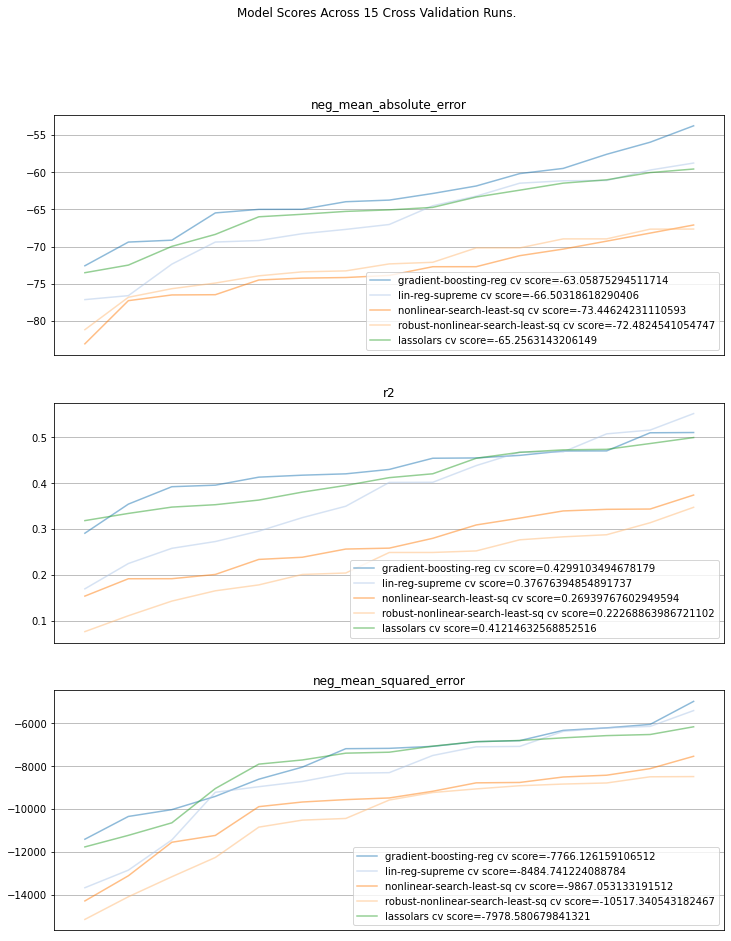

In [17]:
vbhelper.plotCVScores(sort=1)